# DataSet preparation pipeline

In [101]:
import datetime
import numpy as np
import pandas as pd
from modules.pipeline import Pipeline
from pandas.core.common import SettingWithCopyWarning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=SettingWithCopyWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [5]:
pipe = Pipeline()

In [6]:
# TODAY = datetime.datetime.now()
TODAY = datetime.datetime.strptime("23.03.2022", "%d.%m.%Y")
# START_DAY: remove out old data
START_DAY = TODAY - datetime.timedelta(days=365 * 2)
# MIN_RATINGS: remove users with too little unique item ratings 
MIN_RATINGS = 10
# TEMPORAL_SPLIT: time period for testing split (in days)
TEMPORAL_SPLIT = (30 * 3)
# TEMPORAL_PERIODS: number of rolling testing splits
TEMPORAL_PERIODS = 3
# SAVE_PATH: where to save binary train test data
SAVE_PATH = './data/split'

In [60]:
def row_rank4(row):
    return row.price / row.cust_mean_basket

In [59]:
def row_rank3(row):
    return row.invoice_no

In [299]:
def row_rank2(row):
    extra = 0
    if (row.quant_pos > 5) and (row.invoice_no > 3) :
        if row.recent <= 30:
            extra += 20
        if row.median_interval <= (30 * 3):
            extra += 10
    return (row.invoice_no * (1 - row.return_ratio) * np.log1p(row.unit_price)) + extra

In [1]:
def row_rank(row):
    is_low_quantity = row.quant_pos <= 3
    is_recent = row.recent <= 30
    is_frequent = row.median_interval <= (30 * 3)
    is_not_returned = row.return_ratio <= 0.33
    is_large_volume = row.quantity >= row['quantile']
    has_more_transactions = row.invoice_no > 1
    
    if(is_low_quantity):
        if(is_recent):
            if(has_more_transactions):
                return 75
            return 50
        if(is_not_returned):
            return 25
        return 5
    
    if(is_recent):
        if(is_frequent):
            if(is_large_volume):
                return 100
            return 85
        if(row.high_value):
            return 75
        return 60
    
    if(is_not_returned):
        if(is_frequent):
            if(is_large_volume):
                return 70
            if(row.high_value):
                return 60
            return 50
        if(row.high_value):
            return 50
        return 40
    return 10

In [84]:
def group_total(df):
    df_total = df[['cust_id', 'sku', 'quant_pos', 'quant_neg', 'high_value', 'quantity', 'price']] \
        .groupby(['cust_id', 'sku']).sum()
    df_total['price'] = df_total['price'].clip(lower=0)
    df_total['return_ratio'] = np.abs(df_total.quant_neg) / np.abs(df_total.quant_pos)
    df_total['high_value'] = df_total['high_value'].apply(lambda x: True if x > 0 else False)
    df_total = df_total.drop(columns=['quant_neg'])
    return df_total


def group_date(df, today):
    df_dates = df.loc[df.quantity > 0] \
                .sort_values(by='ddate').groupby(['cust_id', 'sku']).agg({
        'ddate' : [('recent', lambda x: today - x.max()), 
                   ('median_interval', lambda x: x.diff().median().total_seconds() / (60*60*24))]
    }).droplevel(0, axis=1)
    df_dates['recent'] = df_dates['recent'].dt.days
    return df_dates


def generate_ranking(df, df_prod, today, algorithm='rank1'):
    # helper columns
    df['quant_pos'] = df.quantity.apply(lambda x: x if x > 0 else 0)
    df['quant_neg'] = df.quantity.apply(lambda x: x if x < 0 else 0)
    df['high_value'] = (df.price / df.quantity) >= 400
    # group by all operations
    df_total = group_total(df)
    # group by transactions (invoices)
    df_ops = df[['cust_id', 'sku', 'invoice_no']].groupby(['cust_id', 'sku']).count()
    # group by basket (operations = days)
    df_basket = df[['cust_id', 'sku', 'ddate', 'quantity', 'price']] \
            .groupby(['cust_id', 'sku', 'ddate']).sum().reset_index()
    # group by product in a basket
    sku_percentiles = df_basket.groupby('sku') \
           .agg({'quantity': [('quantile', lambda x: np.quantile(x, 0.9))]}) \
           .droplevel(0, axis=1).reset_index()
    # group by date
    df_dates = group_date(df_basket, today)
    # group by customer
    df_cust = df[['cust_id', 'invoice_no', 'price']].groupby(['cust_id', 'invoice_no']).sum() \
                .groupby('cust_id').mean()['price'].clip(lower=20)
    df_cust = df_cust.rename('cust_mean_basket')
    # combine
    df_metrics = pd.merge(df_total, df_ops, on=['cust_id', 'sku'])
    df_metrics = pd.merge(df_metrics, df_dates, on=['cust_id', 'sku'], how='left')
    df_metrics = pd.merge(df_metrics.reset_index(), sku_percentiles, on='sku', how='left')
    df_metrics = pd.merge(df_metrics, df_prod[['sku', 'unit_price']], on='sku', how='left')
    df_metrics = pd.merge(df_metrics, df_cust, on='cust_id', how='left')
    # apply ranking
    if algorithm == 'rank1':
        df_metrics['rank'] = df_metrics.apply(row_rank, axis=1)
    if algorithm == 'rank2':
        df_metrics['rank'] = df_metrics.apply(row_rank2, axis=1)
        scaler = MinMaxScaler(feature_range=(0, 100))
        df_metrics['rank'] = scaler.fit_transform(df_metrics['rank'].values.reshape(-1, 1))
    if algorithm == 'rank3':
        df_metrics['rank'] = df_metrics.apply(row_rank3, axis=1)
        df_metrics['rank'] = df_metrics['rank'].clip(0, 5)
    if algorithm == 'rank4':
        df_metrics['rank'] = df_metrics.apply(row_rank4, axis=1)
        df_metrics['rank'] = df_metrics['rank'].clip(0, 10)
        df_metrics['rank'] = np.log1p(df_metrics['rank'])
        scaler = MinMaxScaler(feature_range=(0, 100))
        df_metrics['rank'] = scaler.fit_transform(df_metrics['rank'].values.reshape(-1, 1))
    return df_metrics[['sku', 'cust_id', 'rank']]

In [85]:
df = pipe.df_sals
df_prod = pipe.df_prod

In [86]:
def fix_ratings(row):
    if (np.isnan(row.rank_x)):
        return row.rank_y
    if (row.rank_x != row.rank_y):
        return row.rank_x
    return row.rank_y

In [96]:
# GLOBAL TEMPORAL SPLIT
for period in range(TEMPORAL_PERIODS):
    # prepare transaction split based on montly periods
    start_day = START_DAY + datetime.timedelta(days=TEMPORAL_SPLIT * (TEMPORAL_PERIODS - period))
    max_date = TODAY - datetime.timedelta(days=TEMPORAL_SPLIT * period)
    split_date = TODAY - datetime.timedelta(days=TEMPORAL_SPLIT * (period + 1))
    full_train = df.loc[(df.ddate >= start_day) & (df.ddate < split_date)]
    full_train_date = full_train[['sku', 'cust_id', 'ddate']].groupby(['sku', 'cust_id']).max()
    full_test = df.loc[(df.ddate >= start_day) & (df.ddate <= max_date)]
    full_test_date = full_test[['sku', 'cust_id', 'ddate']].groupby(['sku', 'cust_id']).max()
    # apply rating algorithm
    full_train = generate_ranking(full_train, df_prod, split_date, algorithm='rank4')
    full_test = generate_ranking(full_test, df_prod, max_date, algorithm='rank4')
    full = pd.merge(full_train, full_test, on=['sku', 'cust_id'], how='right')
    # fix differing ranks
    full['rank'] = full.apply(fix_ratings, axis=1)
    # remove users with less than 10 unique ratings
    good_cust = full.loc[~full.rank_x.isna()].groupby('cust_id').count()['sku'] >= MIN_RATINGS
    good_cust = good_cust[good_cust == True].index
    full = full.loc[full.cust_id.isin(good_cust)]
    # split ranking into train test
    train = full.loc[~full.rank_x.isna(), ['sku', 'cust_id', 'rank_x']]
    train = train.rename(columns={'rank_x': 'rank'})
    test = full.loc[full.rank_x.isna(), ['sku', 'cust_id', 'rank']]
    # remove items and users which are not present in train (cold start)
    train_items = train.sku.unique()
    train_custs = train.cust_id.unique()
    test = test.loc[test.sku.isin(train_items) & test.cust_id.isin(train_custs) & ~test['rank'].isna()]
    # add time to train
    train = pd.merge(train, full_train_date, on=['sku', 'cust_id'], how='left')
    train['ddate'] = train['ddate'].astype('int64') // 10**9
    test = pd.merge(test, full_test_date, on=['sku', 'cust_id'], how='left')
    test['ddate'] = test['ddate'].astype('int64') // 10**9
    # save
    train.to_pickle(f'{SAVE_PATH}/train_gts_{period}.pkl')
    test.to_pickle(f'{SAVE_PATH}/test_gts_{period}.pkl')

## Check the distribution of training and testing set

In [99]:
import matplotlib.pyplot as plt

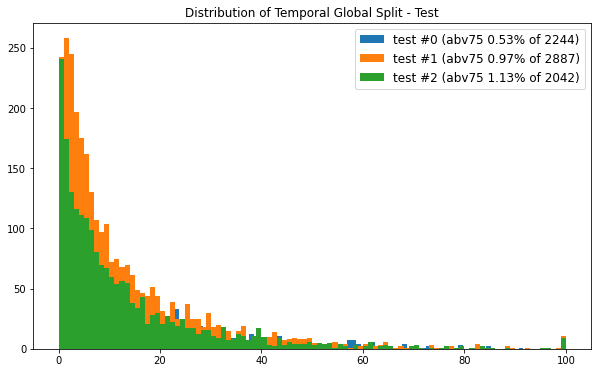

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,6))
ax.set_title(f'Distribution of Temporal Global Split - Test')

for i in range(TEMPORAL_PERIODS):
    test = pd.read_pickle(f'{SAVE_PATH}/test_{i}.pkl')
    total = test.shape[0]
    abv75 = test.loc[test['rank'] >= 75].shape[0]
    ax.hist(test['rank'], bins=100, label=f'test #{i} (abv75 {round((abv75 / total) * 100, 2)}% of {total})')
    ax.legend(prop={'size': 12})

Sparsity: 0.955%
Sparsity: 0.954%
Sparsity: 0.953%


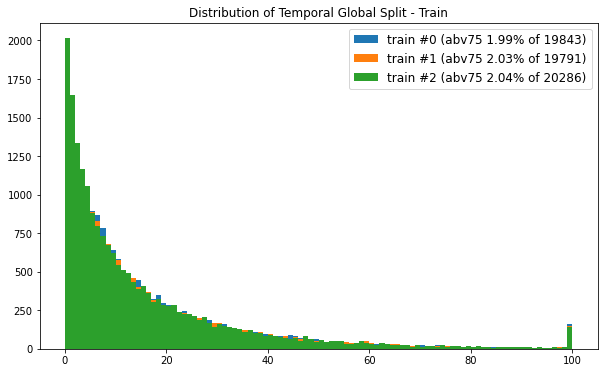

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,6))
ax.set_title(f'Distribution of Temporal Global Split - Train')

for i in range(TEMPORAL_PERIODS):
    train = pd.read_pickle(f'{SAVE_PATH}/train_{i}.pkl')
    val = round(np.isnan(train.pivot_table(index='cust_id', columns='sku', values='rank').to_numpy()).mean(), 3)
    print(f'Sparsity: {val}%')
    total = train.shape[0]
    abv75 = train.loc[train['rank'] >= 75].shape[0]
    ax.hist(train['rank'], bins=100, label=f'train #{i} (abv75 {round((abv75 / total) * 100, 2)}% of {total})')
    ax.legend(prop={'size': 12})

(2244, 3)
(2887, 3)
(2042, 3)


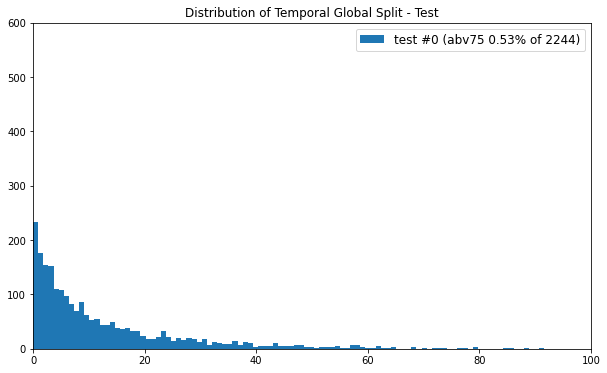

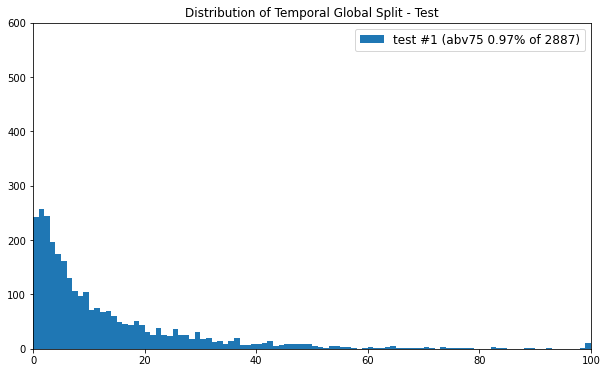

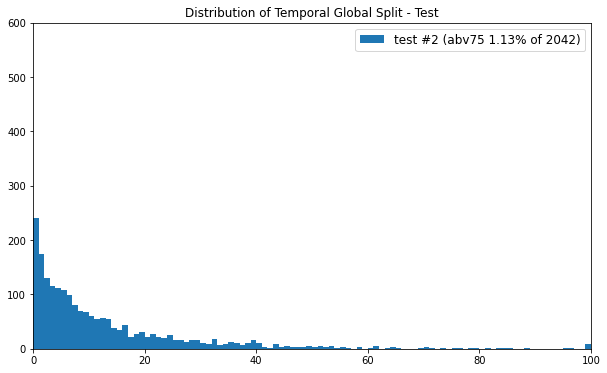

In [91]:
for i in range(TEMPORAL_PERIODS):
    test = pd.read_pickle(f'{SAVE_PATH}/test_{i}.pkl')
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(10,6))
    ax.set_title(f'Distribution of Temporal Global Split - Test')
    print(test.loc[~test['rank'].isna()].shape)

    total = test.shape[0]
    abv75 = test.loc[test['rank'] >= 75].shape[0]
    ax.hist(test['rank'], bins=100, label=f'test #{i} (abv75 {round((abv75 / total) * 100, 2)}% of {total})')
    ax.set_xlim(left=0, right=100)
    ax.set_ylim(bottom=0, top=600)
    ax.legend(prop={'size': 12})